Usa numpy 1.24.3
    pandas 2.1.1
    sklearn 1.6.1

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import re
import json

In [36]:
countries = [
    "Argentina",
    "Bolivia",
    "Chile",
    "Colombia",
    "Costa Rica",
    "Cuba",
    "Ecuador",
    "El Salvador",
    "Guatemala",
    "Honduras",
    "Mexico",
    "Nicaragua",
    "Panama",
    "Paraguay",
    "Peru",
    "Puerto Rico",
    "Dominican Republic",
    "Uruguay",
    "Venezuela",
    "Spain"
]
print(len(countries))  # 20

20


In [37]:
def correlation(data):
    sigma = data.std(axis=0)
    c = np.zeros((data.shape[1], data.shape[1]))
    
    for row in range(data.shape[1]):
        for col in range(row,data.shape[1]):
            if col == row:
                c[row, col] = 1.0
            else:
                cov = np.cov(data.iloc[:, row], data.iloc[:, col])[0][1]
                c[row, col] = cov / (sigma[row] * sigma[col])
                c[col, row] = c[row, col]
    return c

In [38]:
d = pd.DataFrame(np.array([[25,50,4],
                           [30,60,5],
                           [22,55,3],
                           [35,65,5],
                           [28,48,2],
                           [45,75,3],
                           [50,80,6],
                           [34,58,4],
                           [40,70,2],
                           [24,52,3]
                           ]))
correlation(d)

array([[1.        , 0.93886362, 0.33688942],
       [0.93886362, 1.        , 0.38778648],
       [0.33688942, 0.38778648, 1.        ]])

# Indices

In [39]:
path = "./datasets/CPI2024-Results-and-trends.csv"
df = pd.read_csv(path, header=2, encoding="ISO-8859-1", sep=';')
df = df[df["Country / Territory"].isin(countries)]
df.dropna(how="all", axis=1, inplace=True)
df.rename(columns={"Country / Territory": "country"}, inplace=True)
df.set_index('country', inplace=True)

cpi2024_sources = {
    "rank": "Rank",
    "cpi": "CPI 2024 score"}
df.rename(columns=dict(zip(cpi2024_sources.values(), cpi2024_sources.keys())), inplace=True)

df.drop(columns=[i for i in df.columns if i not in cpi2024_sources.keys()], inplace=True)
df = df.reindex(countries)
df.dropna(how='all', inplace=True)
df

,cpi,rank
country,,
Argentina,37.0,99.0
Bolivia,28.0,133.0
Chile,63.0,32.0
Colombia,39.0,92.0
Costa Rica,58.0,42.0
Cuba,41.0,82.0
Ecuador,32.0,121.0
El Salvador,30.0,130.0
Guatemala,25.0,146.0


<Axes: >

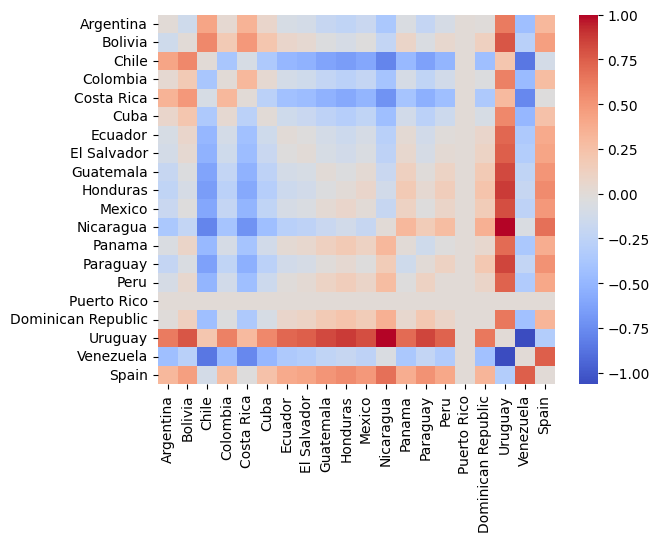

In [40]:
dist = np.zeros((len(countries), len(countries)))
for i, ci in enumerate(countries):
    for j, cj in enumerate(countries):
        if i != j:
            try:
                dist[i, j] = df.loc[ci, 'cpi'] - df.loc[cj, 'cpi']
            except KeyError:
                dist[i, j] = 0.0
            dist[j, i] = dist[i, j]
dist = pd.DataFrame(dist/dist.max(), index=countries, columns=countries)
sns.heatmap(dist, annot=False, cmap='coolwarm')

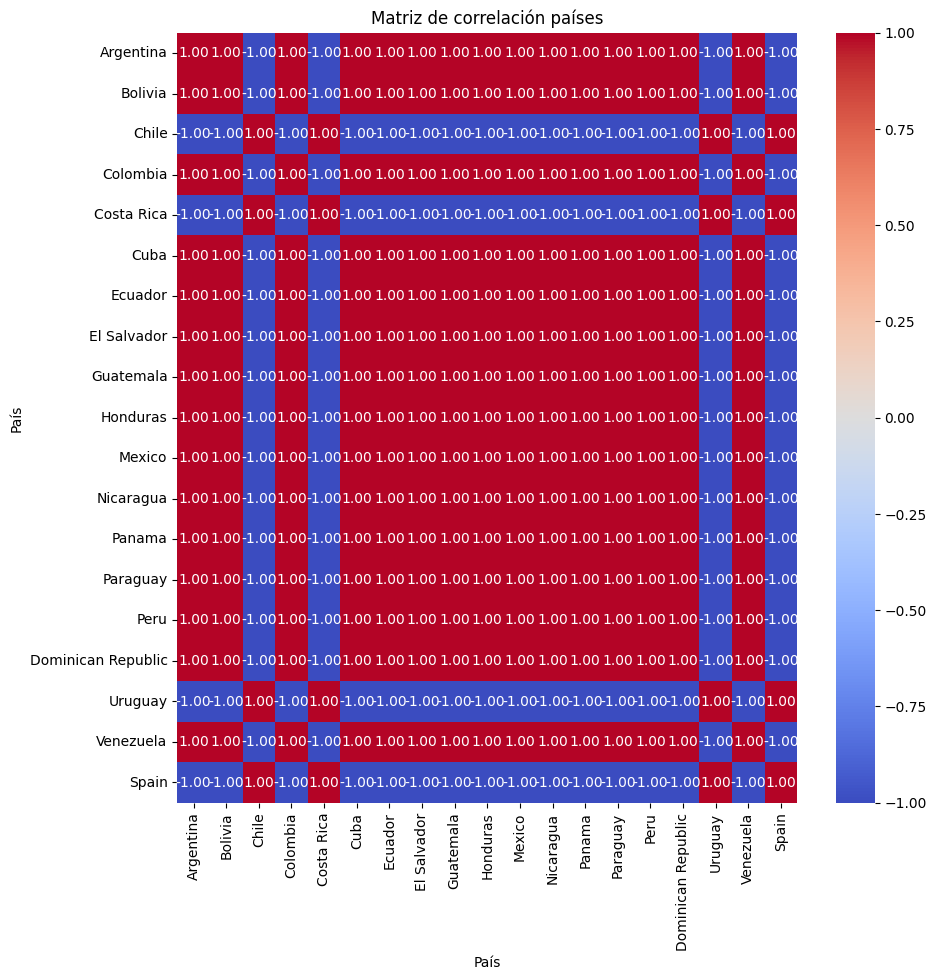

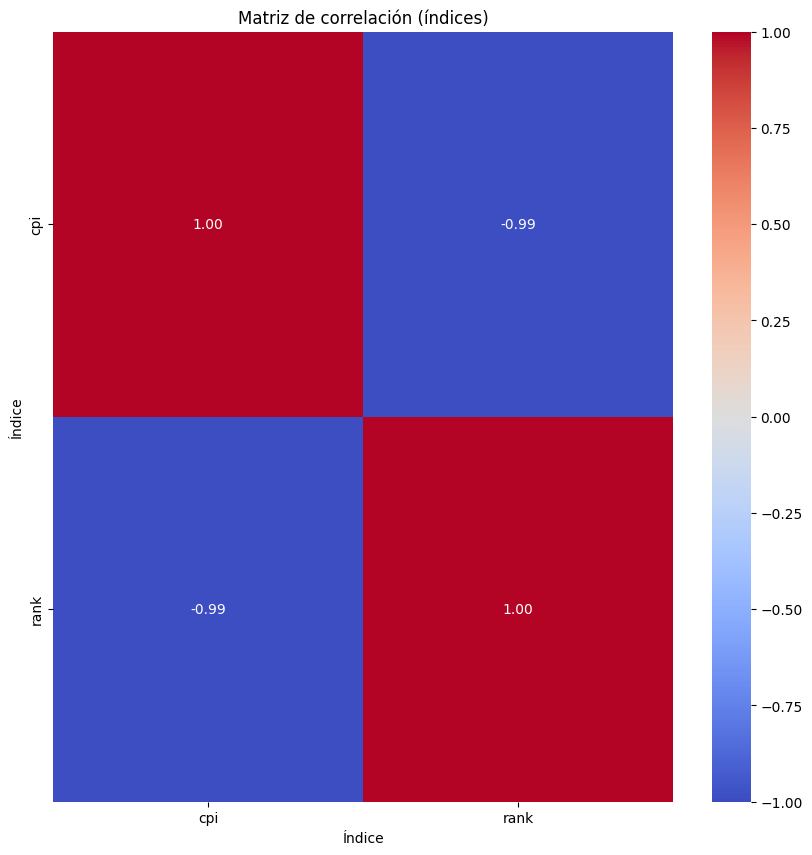

In [41]:
corr = df.T.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
#sns.heatmap(np.abs(corr), annot=True, cmap="coolwarm", vmin=0, vmax=1, fmt=".1f")
plt.title("Matriz de correlación países")
plt.xlabel("País")
plt.ylabel("País")
plt.show()

#corrT = correlation(df.T)

corrT = df.corr()

plt.figure(figsize=(10,10))
#sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
sns.heatmap(corrT, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matriz de correlación (índices)")
plt.xlabel("Índice")
plt.ylabel("Índice")
plt.show()

In [42]:
type(corr)

pandas.core.frame.DataFrame

# Busquedas

In [43]:
# Leer el archivo JSON guardado
Nombre_Archivo = f"../buscador/resultados/resultados_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    resultados = json.load(file)

# Leer el archivo JSON guardado
Nombre_Archivo = f"../buscador/resultados/res_unicos_corrupcion.json"

with open(Nombre_Archivo, "r") as file:
    all_hrefs = json.load(file)

## Correlacion

In [44]:
import pandas as pd
from math import isnan
from scipy.stats import kendalltau, spearmanr, pearsonr

def build_aligned_ranks(rank_list, universe, top, absent_policy="max_plus_one"):
    """
    rank_list: lista de dicts con clave 'href', en orden de ranking.
    universe: lista/iterable con todos los hrefs a alinear.
    top: entero, cuántos tomas de rank_list.
    absent_policy:
      - 'max_plus_one': rank = len(universe) + 1 a los ausentes
      - '1.5top': rank = int(1.5 * top) a los ausentes
    """
    pos = {item['href']: i+1 for i, item in enumerate(rank_list)}  # 1..len(list)
    if absent_policy == "max_plus_one":
        absent_rank = len(universe) + 1
    elif absent_policy == "1.5top":
        absent_rank = int(1.5 * top)
    else:
        absent_rank = len(universe) + 1
    return [pos.get(u, absent_rank) for u in universe]

def correlation_matrix(results, universe, top, method="spearman", absent_policy="max_plus_one"):
    """
    results: lista de dicts con llaves ["country"] y ["search_results"]["results"]
    method: "spearman" (rho) o "kendall" (tau-b)
    """
    countries = [c["country"] for c in results]
    aligned = {
        c["country"]: build_aligned_ranks(
            c["search_results"]["results"][:top], universe, top, absent_policy=absent_policy
        )
        for c in results
    }

    corr_data, pval_data = [], []
    for c1 in countries:
        row_corr, row_p = [], []
        x = aligned[c1]
        for c2 in countries:
            y = aligned[c2]
            if method == "spearman":
                r, p = spearmanr(x, y)
            elif method == "kendall":
                r, p = kendalltau(x, y)
            else:
                raise ValueError("method debe ser 'spearman' o 'kendall'")
            row_corr.append(0.0 if (r is None or isnan(r)) else float(r))
            row_p.append(1.0 if (p is None or isnan(p)) else float(p))
        corr_data.append(row_corr)
        pval_data.append(row_p)

    corr_df = pd.DataFrame(corr_data, index=countries, columns=countries)
    p_df    = pd.DataFrame(pval_data, index=countries, columns=countries)
    return corr_df, p_df, aligned


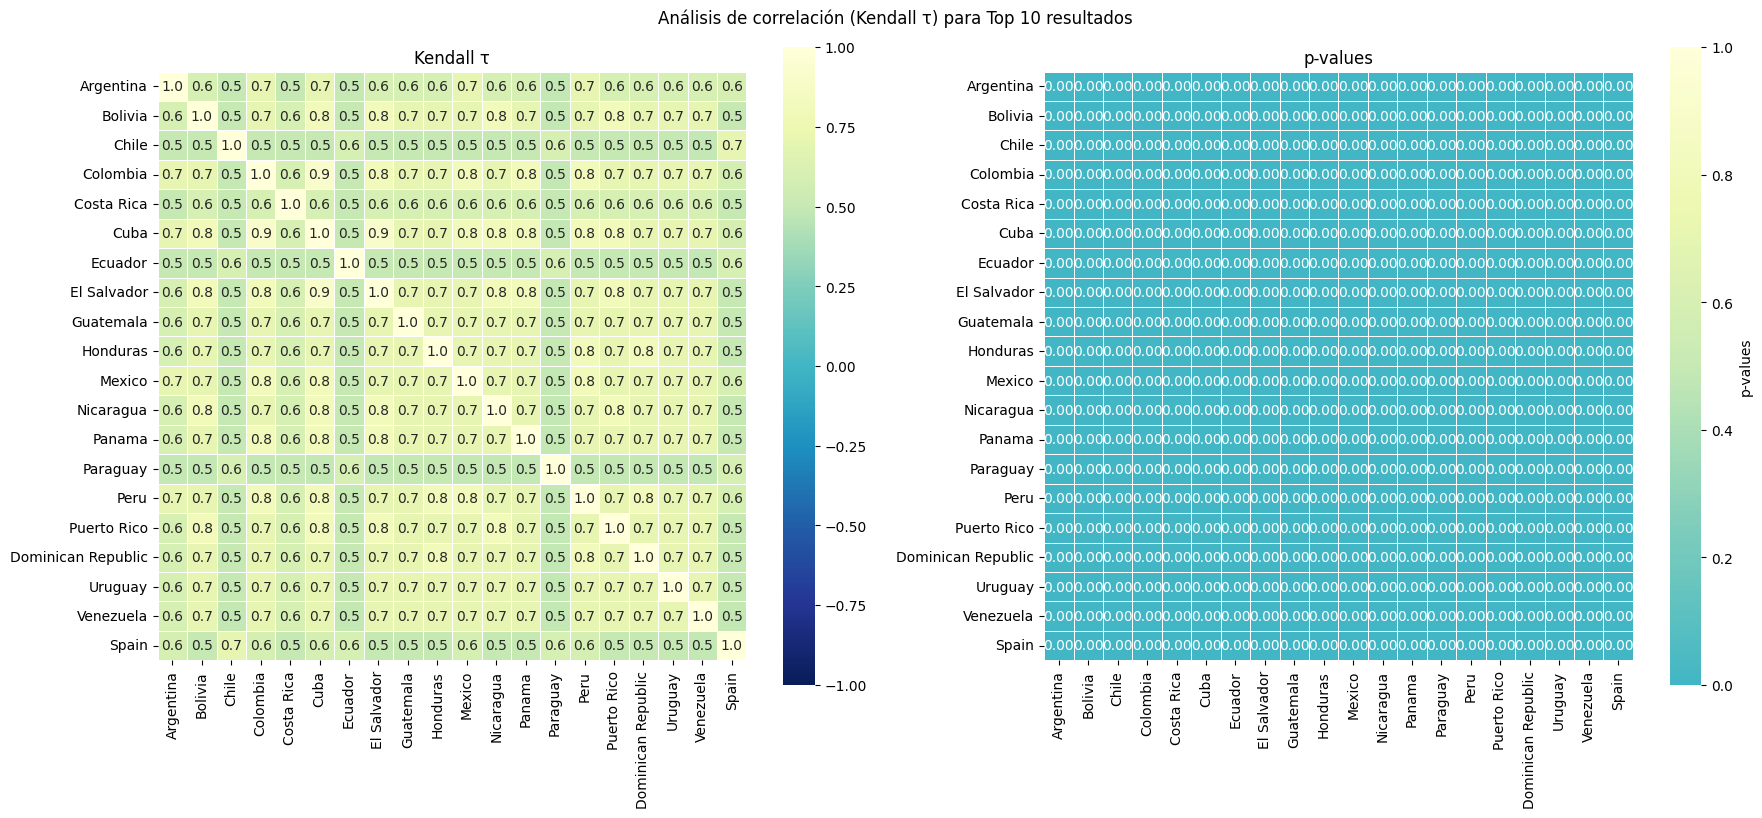

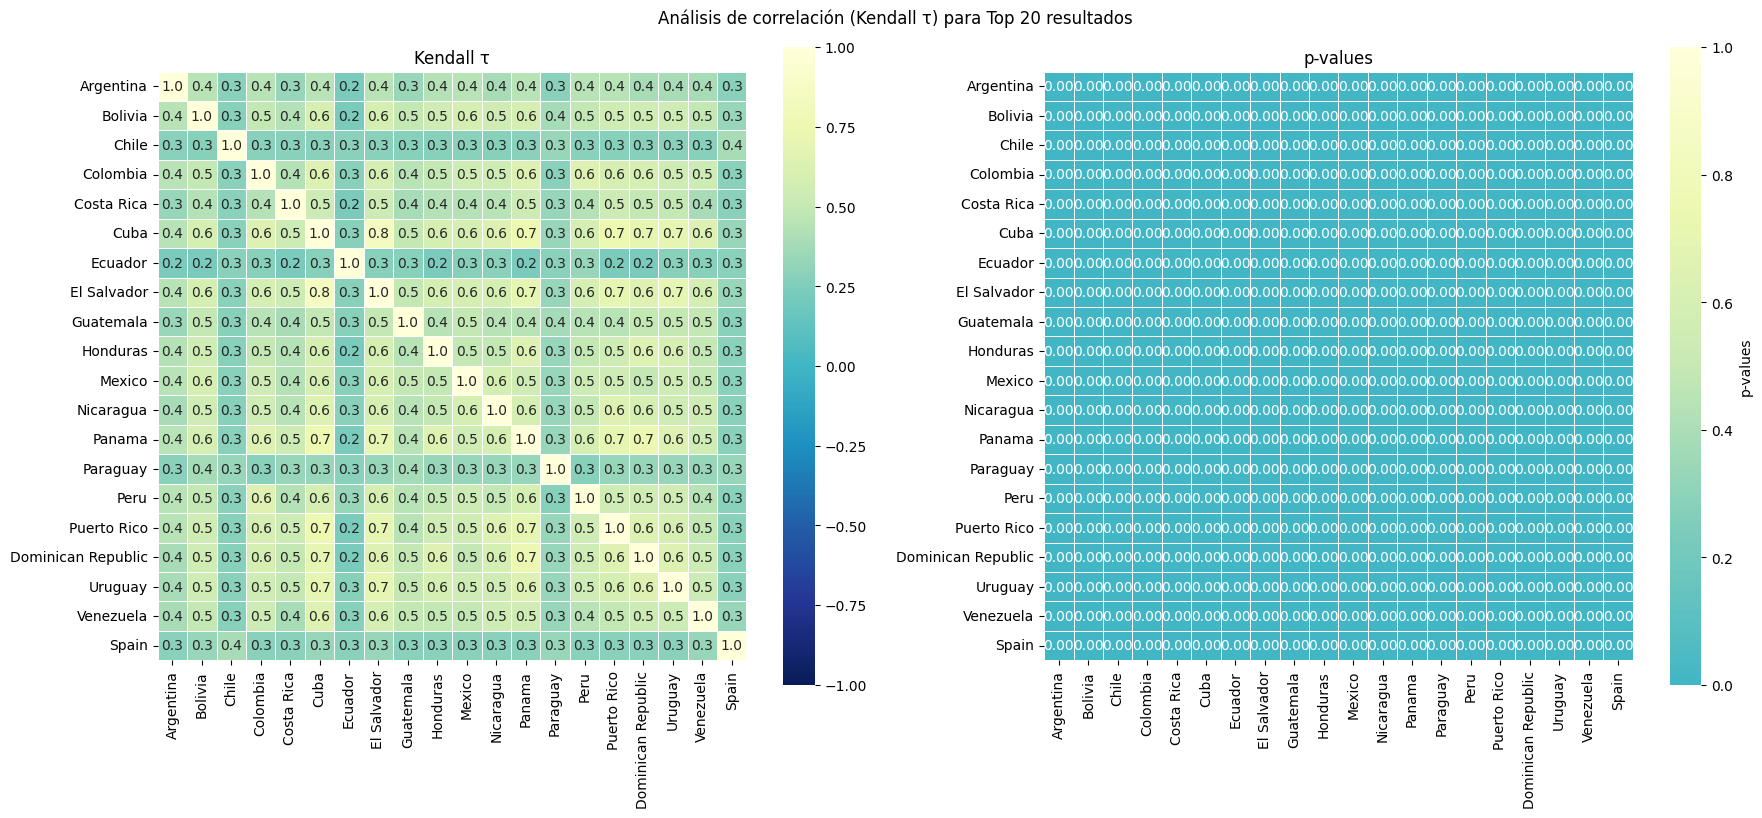

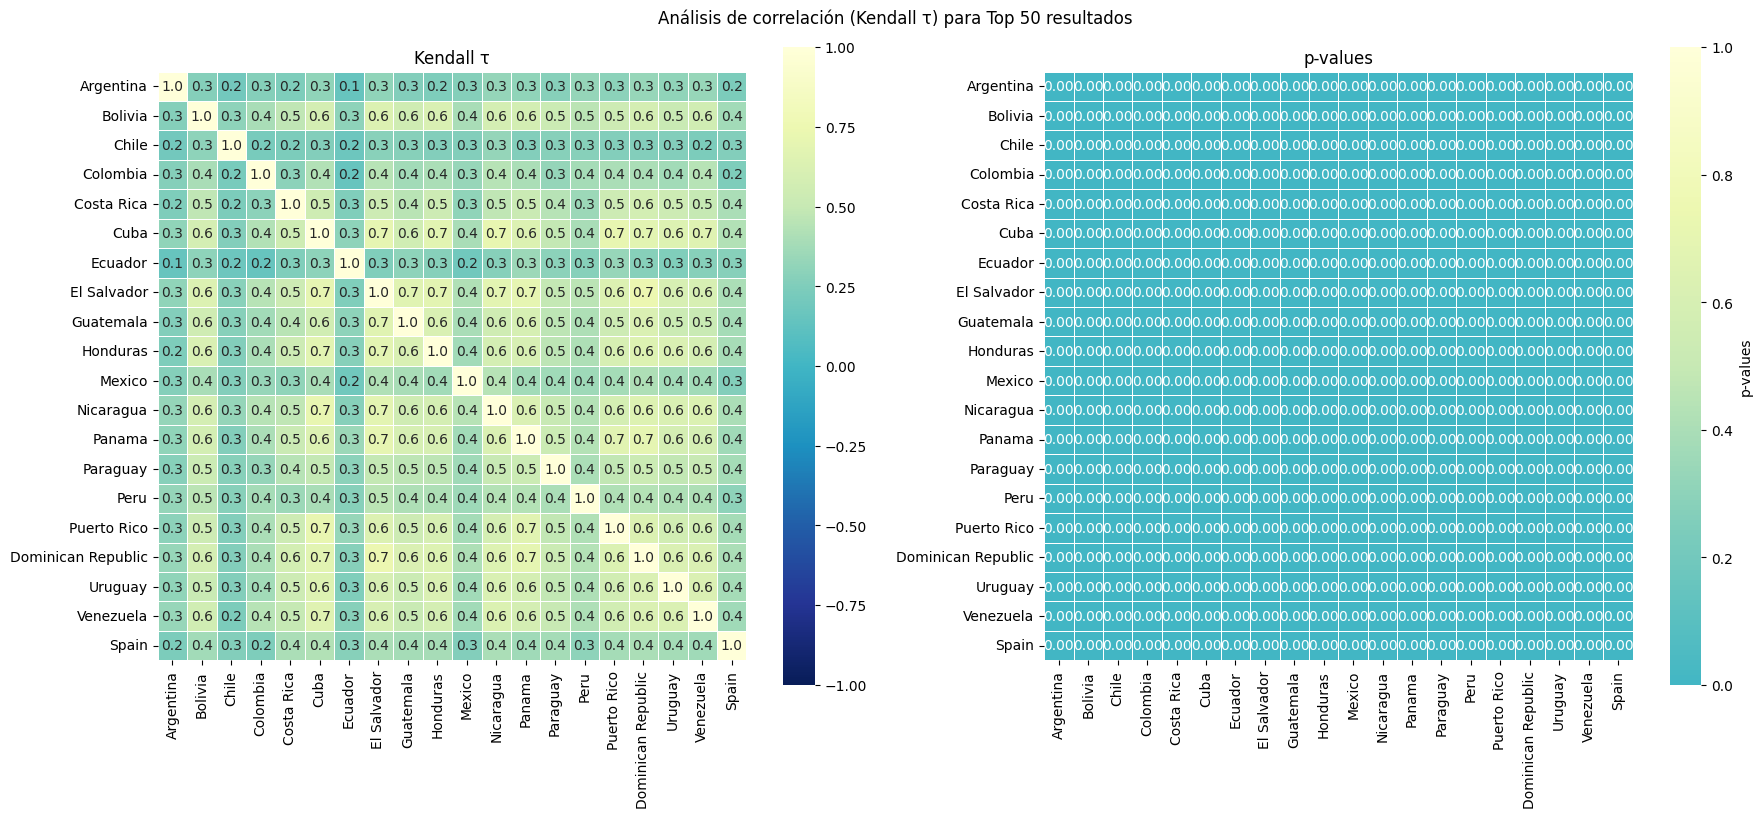

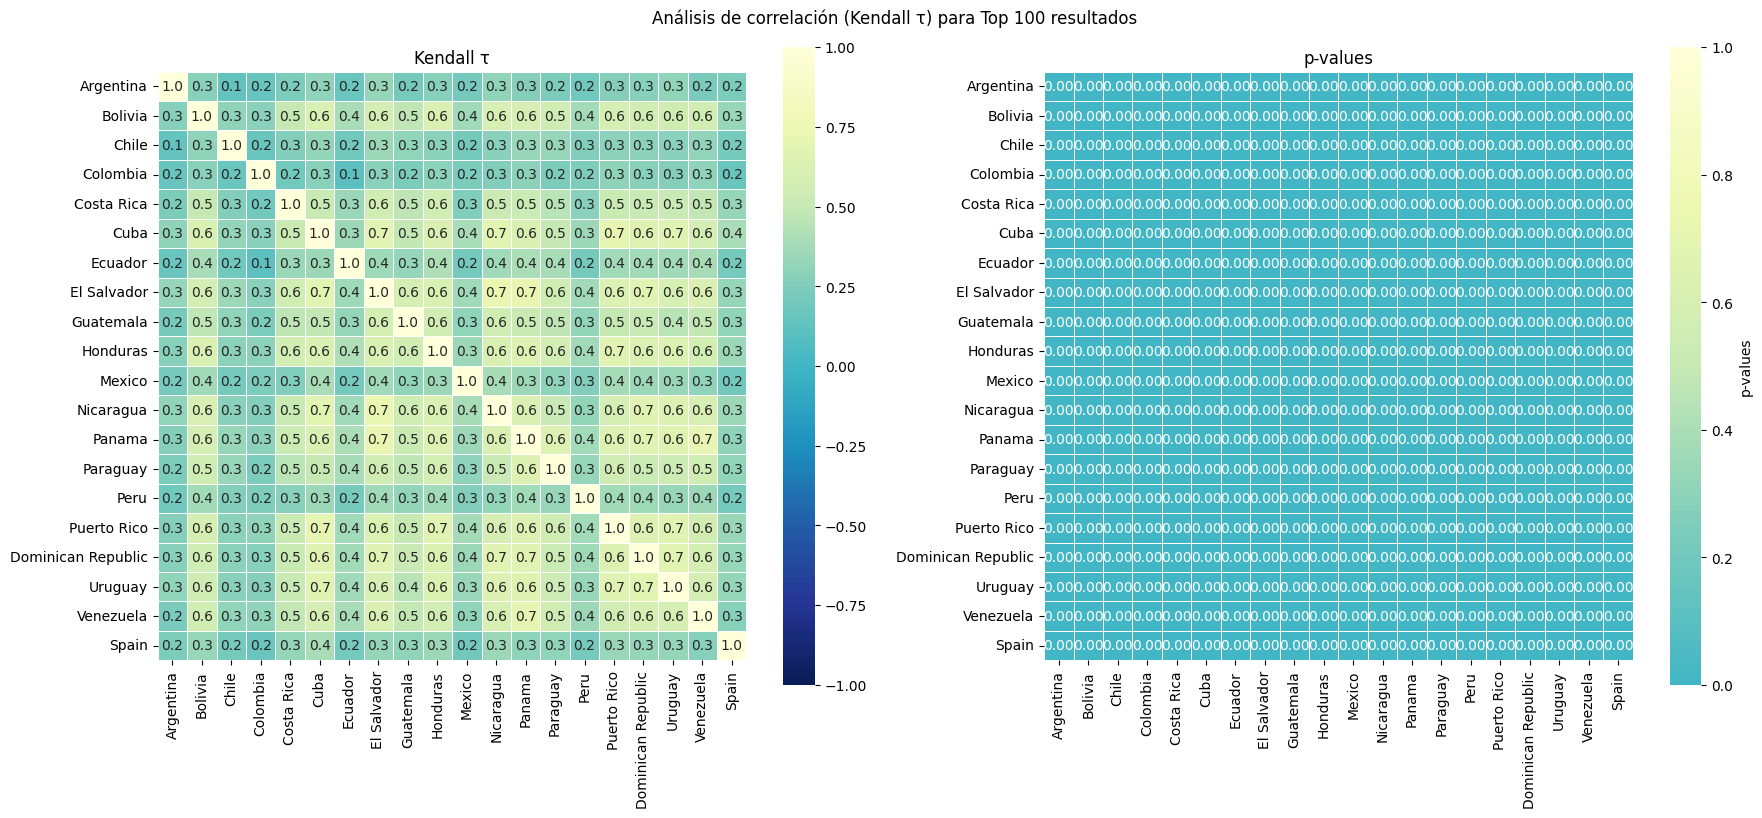

In [45]:
method = "kendall"  # "spearman" o "kendall"

for top in [10, 20, 50, 100]:
    rho, p, _ = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top")

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    method_dict = {"spearman": "Spearman ρ", "kendall": "Kendall τ"}
    cbar_kws={"label": method_dict[method]}

    # Heatmap method
    sns.heatmap(
        rho, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".1f", vmin=-1, vmax=1, linewidths=0.5, square=True,
        **cbar_kws, ax=axes[0]
    )

    axes[0].set_title(method_dict[method])

    # Heatmap p-values
    sns.heatmap(
        p, annot=True, cmap="YlGnBu_r", center=0,
        fmt=".2f", vmin=0, vmax=1, linewidths=0.5, square=True,
        cbar_kws={"label": "p-values"}, ax=axes[1]
    )
    axes[1].set_title("p-values")

    plt.suptitle(f"Análisis de correlación ({method_dict[method]}) para Top {top} resultados")
    plt.tight_layout()
    plt.show()


# Indices-BusquedasCorr-BusquedasTras-Aleatoria-Distancia-Desglosado
## Matriz distancia entre capitales

In [46]:
import math
# Coordenadas (lat, lon) de capitales (aprox)
capital_coords = {
    "Argentina": (-34.6037, -58.3816),            # Buenos Aires
    "Bolivia": (-16.4897, -68.1193),              # La Paz (sede de gobierno)
    "Chile": (-33.4489, -70.6693),                 # Santiago
    "Colombia": (4.7110, -74.0721),                # Bogotá
    "Costa Rica": (9.9281, -84.0907),              # San José
    "Cuba": (23.1136, -82.3666),                   # La Habana
    "Ecuador": (-0.1807, -78.4678),                # Quito
    "El Salvador": (13.6929, -89.2182),            # San Salvador
    "Guatemala": (14.6349, -90.5061),              # Ciudad de Guatemala
    "Honduras": (14.0723, -87.1921),               # Tegucigalpa
    "Mexico": (19.4326, -99.1332),                 # Ciudad de México
    "Nicaragua": (12.1140, -86.2362),              # Managua
    "Panama": (8.9824, -79.5199),                  # Ciudad de Panamá
    "Paraguay": (-25.2637, -57.5759),              # Asunción
    "Peru": (-12.0464, -77.0428),                  # Lima
    "Puerto Rico": (18.4655, -66.1057),            # San Juan
    "Dominican Republic": (18.4861, -69.9312),     # Santo Domingo
    "Uruguay": (-34.9011, -56.1645),               # Montevideo
    "Venezuela": (10.4806, -66.9036),              # Caracas
    "Spain": (40.4168, -3.7038)                    # Madrid
}

# Función Haversine (km)
def haversine_km(coord1, coord2):
    R = 6371.0088  # radio medio de la Tierra en km
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (math.sin(dlat/2)**2
         + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2)
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Construir la matriz (en el mismo orden que countries)
n = len(countries)
D = np.zeros((n, n), dtype=float)

for i, ci in enumerate(countries):
    for j, cj in enumerate(countries):
        if i == j:
            D[i, j] = 0.0
        else:
            D[i, j] = haversine_km(capital_coords[ci], capital_coords[cj])

# DataFrame cuadrado país x país (normalizado 0..1)
dist_matrix = pd.DataFrame(D/D.max(), index=countries, columns=countries)
dist_matrix

,Argentina,Bolivia,Chile,Colombia,Costa Rica,Cuba,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Puerto Rico,Dominican Republic,Uruguay,Venezuela,Spain
Argentina,0.000000,0.208884,0.106421,0.436413,0.527375,0.644683,0.407404,0.586834,0.601879,0.580192,0.690724,0.557697,0.498319,0.097313,0.293159,0.556649,0.563288,0.019177,0.475894,0.938599
Bolivia,0.208884,0.000000,0.177817,0.228609,0.319833,0.436198,0.199874,0.381119,0.396643,0.373023,0.489514,0.350660,0.289447,0.136945,0.100993,0.363769,0.363872,0.221200,0.280501,0.856755
Chile,0.106421,0.177817,0.000000,0.397893,0.469823,0.598986,0.353945,0.523156,0.536891,0.520194,0.617647,0.497864,0.449454,0.145706,0.230461,0.541288,0.539656,0.125480,0.457947,1.000000
Colombia,0.436413,0.228609,0.397893,0.000000,0.116575,0.208529,0.068297,0.181062,0.197184,0.165838,0.296273,0.146708,0.071599,0.353145,0.176794,0.164200,0.149168,0.447272,0.095074,0.748609
Costa Rica,0.527375,0.319833,0.469823,0.116575,0.000000,0.138064,0.120046,0.065178,0.081429,0.053357,0.180385,0.031536,0.047864,0.453559,0.239630,0.201489,0.167913,0.540678,0.175822,0.792649
Cuba,0.644683,0.436198,0.598986,0.208529,0.138064,0.000000,0.245213,0.118866,0.118942,0.105244,0.166666,0.120515,0.149533,0.561219,0.369306,0.165045,0.129930,0.655775,0.201867,0.695206
Ecuador,0.407404,0.199874,0.353945,0.068297,0.120046,0.245213,0.000000,0.181711,0.197489,0.173156,0.293000,0.150787,0.095825,0.334509,0.124158,0.231212,0.212627,0.420632,0.162935,0.816429
El Salvador,0.586834,0.381119,0.523156,0.181062,0.065178,0.118866,0.181711,0.000000,0.016252,0.020813,0.115301,0.034367,0.110225,0.516219,0.295380,0.235813,0.198743,0.600858,0.229057,0.808345
Guatemala,0.601879,0.396643,0.536891,0.197184,0.081429,0.118942,0.197489,0.016252,0.000000,0.033866,0.099113,0.050483,0.126174,0.531976,0.309924,0.246049,0.208640,0.616056,0.243085,0.812255
Honduras,0.580192,0.373023,0.520194,0.165838,0.053357,0.105244,0.173156,0.020813,0.033866,0.000000,0.131143,0.022529,0.094300,0.506916,0.290804,0.215056,0.178053,0.593690,0.209245,0.789968


## Traslape

In [47]:
def graph_heatmap(resultados, tops, show=True):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Crear matriz de coincidencias de href
    coincidencias = {}
    for pais in resultados:
        coincidencias[pais["country"]] = {}
        for pais2 in resultados:
            coincidencias[pais["country"]][pais2["country"]] = 0

    for i in range(len(tops)-1):
        for pais in resultados:
            for pais2 in resultados:
                for result in pais["search_results"]["results"][tops[i]:tops[i+1]]:
                    for result2 in pais2["search_results"]["results"][tops[i]:tops[i+1]]:
                        if result["href"] == result2["href"]:
                            coincidencias[pais["country"]][pais2["country"]] += 1

        # Crear matriz de coincidencias
        matriz = []
        for pais in coincidencias:
            matriz.append([coincidencias[pais][pais2] for pais2 in coincidencias])

        if show:
            # Crear heatmap
            plt.figure(figsize=(10, 10))
            sns.heatmap(matriz, annot=True, fmt="d", xticklabels=coincidencias.keys(), yticklabels=coincidencias.keys(), vmin=0, vmax=tops[i+1], cmap="YlGnBu_r")
            plt.title("Matriz de coincidencias de resultados de búsqueda de 'Corrupción' (Top {})".format(tops[i+1]))

            # Guardar heatmap
            # plt.savefig("Coincidencias/heatmap_violencia.png")

            plt.show()

        return pd.DataFrame(np.array(matriz), index=coincidencias.keys(), columns=coincidencias.keys())

# Desglose de indices

In [48]:
df_desglosado = pd.read_csv("./datasets/latam_desglosado_full.csv", index_col=0)
corrDesglosado = df_desglosado.T.corr()
df_desglosado

,cpi,rank,bti_3,bti_15,eiu,gi,prs,vdem,wef,wjp_1,wjp_2,wjp_3,wjp_4
Argentina,37.0,99.0,8.0,70.0,51.0,32.0,33.0,48.0,18.0,0.387976,0.653564,0.591817,0.198507
Bolivia,28.0,133.0,8.0,37.0,35.0,32.0,33.0,34.0,6.0,0.305759,0.158059,0.268814,0.179822
Chile,63.0,32.0,10.0,8.0,67.0,59.0,60.0,70.0,58.0,0.609473,0.820165,0.809936,0.514733
Colombia,39.0,92.0,7.0,74.0,51.0,46.0,33.0,48.0,29.0,0.378315,0.585682,0.515168,0.100250
Costa Rica,58.0,42.0,9.0,10.0,67.0,59.0,42.0,62.0,43.0,0.618600,0.762191,0.737043,0.412653
Cuba,41.0,82.0,2.0,5.0,51.0,32.0,49.0,35.0,NaN,NaN,NaN,NaN,NaN
Ecuador,32.0,121.0,7.0,93.0,35.0,32.0,33.0,30.0,17.0,0.376852,0.371688,0.517290,0.193062
El Salvador,30.0,130.0,5.0,28.0,35.0,32.0,33.0,27.0,23.0,0.310729,0.502008,0.494326,0.082169
Guatemala,25.0,146.0,4.0,38.0,18.0,32.0,28.0,22.0,29.0,0.364479,0.408314,0.520720,0.084689
Honduras,22.0,154.0,4.0,47.0,18.0,19.0,24.0,24.0,14.0,0.344886,0.366355,0.463286,0.103375


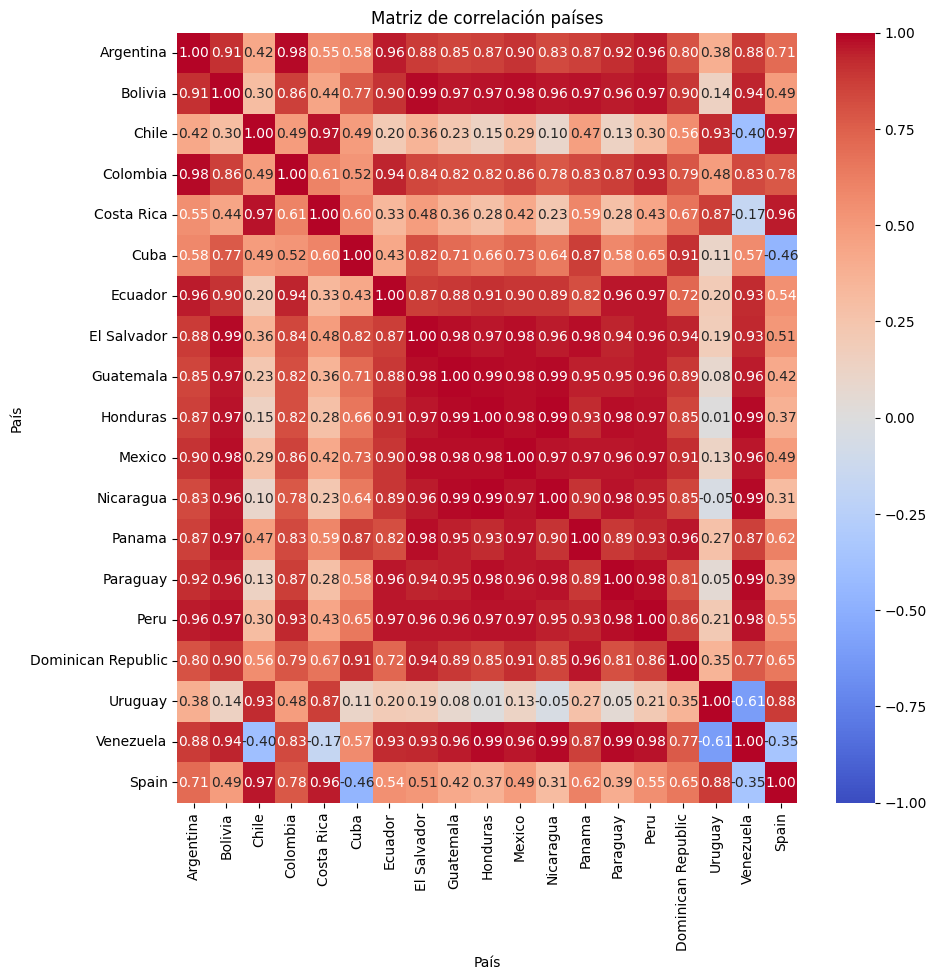

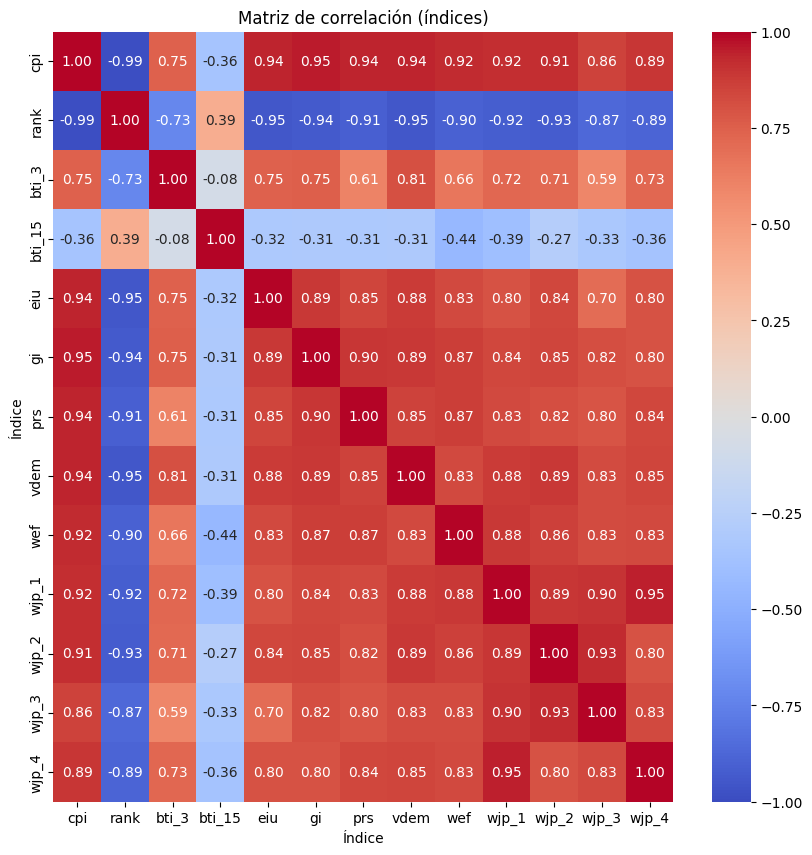

In [49]:
c = df_desglosado.T.corr()

plt.figure(figsize=(10,10))
sns.heatmap(c, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
#sns.heatmap(np.abs(corr), annot=True, cmap="coolwarm", vmin=0, vmax=1, fmt=".1f")
plt.title("Matriz de correlación países")
plt.xlabel("País")
plt.ylabel("País")
plt.show()


cT = df_desglosado.corr()

plt.figure(figsize=(10,10))
#sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
sns.heatmap(cT, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Matriz de correlación (índices)")
plt.xlabel("Índice")
plt.ylabel("Índice")
plt.show()

# Spearman extendido $F^{(k+1)}$

In [50]:
from __future__ import annotations
from typing import Hashable, Iterable, Tuple, Dict, Set

def fk_plus_one(
    list1: Iterable[Hashable],
    list2: Iterable[Hashable],
    k: int,
    normalize: bool = True,
) -> Tuple[float, int]:
    """
    Extended Spearman footrule F^(k+1) (Fagin et al. style) as used in the paper.

    Parameters
    ----------
    list1, list2: ranked lists (best to worst). Items must be hashable.
    k: cutoff for "top-k". We use only the first k items from each list.
    normalize: if True returns F / (k*(k+1)), else returns raw F.

    Returns
    -------
    (value, z) where z is the overlap size |Z| between the two top-k lists.
    """
    if k <= 0:
        raise ValueError("k must be a positive integer")

    # take top-k and keep first occurrence if duplicates appear
    def topk_unique(xs: Iterable[Hashable], k: int) -> list[Hashable]:
        out = []
        seen = set()
        for x in xs:
            if x in seen:
                continue
            seen.add(x)
            out.append(x)
            if len(out) == k:
                break
        return out

    L1 = topk_unique(list1, k)
    L2 = topk_unique(list2, k)

    # ranks are 1-indexed
    r1: Dict[Hashable, int] = {item: idx + 1 for idx, item in enumerate(L1)}
    r2: Dict[Hashable, int] = {item: idx + 1 for idx, item in enumerate(L2)}

    U: Set[Hashable] = set(r1) | set(r2)
    Z: Set[Hashable] = set(r1) & set(r2)
    z = len(Z)

    missing_rank = k + 1
    F = 0
    for item in U:
        a = r1.get(item, missing_rank)
        b = r2.get(item, missing_rank)
        F += abs(a - b)

    if normalize:
        F = F / (k * (k + 1))

    return F, z

def Fk_plus_one_matrix(resultados, countries, k=100):
    Fk_plus_one = np.zeros((len(countries), len(countries)))
    for i, ci in enumerate(countries):
        for j, cj in enumerate(countries):
            if i != j:
                s1 = [item['href'] for item in resultados[i]['search_results']['results']]
                s2 = [item['href'] for item in resultados[j]['search_results']['results']]
                val, overlap = fk_plus_one(s1, s2, k=k, normalize=True)
                Fk_plus_one[i, j] = val
                Fk_plus_one[j, i] = val
    return Fk_plus_one, overlap

# Comparacion

In [51]:
def upper_tri_vals(df):
    mask = np.triu(np.ones(df.shape), k=1).astype(bool)
    return df.where(mask).stack()

In [52]:
method = "kendall"  # "spearman" o "kendall"

all_results = []
order = ["Indices-Busquedas", "Indices-Aleatoria", "Busquedas-Aleatoria", "Indices-Distancia", "Busquedas-Distancia", "Indices-Coincidencias", "Indices-Desglosado", "Indices-Fk+1"]

for top in [10, 20, 50, 100]:
    tau, p, _ = correlation_matrix(resultados, all_hrefs, top, method=method, absent_policy="1.5top")
    Fk_plus_one, overlap = Fk_plus_one_matrix(resultados, countries, k=top)
    tras = graph_heatmap(resultados, [0, top], show=False)

    # Obtener variables (paises) comunes
    common_vars = dist.index.intersection(tau.index)
    if 'Puerto Rico' in common_vars:
        common_vars = common_vars.drop('Puerto Rico')
    m1 = dist.loc[common_vars, common_vars]
    m2 = tau.loc[common_vars, common_vars]
    m5 = tras.loc[common_vars, common_vars]
    m6 = corrDesglosado.loc[common_vars, common_vars]
    m7 = pd.DataFrame(Fk_plus_one, index=countries, columns=countries).loc[common_vars, common_vars]

    n = len(common_vars)
    rand = np.random.rand(n, n)
    rand = (rand + rand.T) / 2  # simétrica
    np.fill_diagonal(rand, 1.0)
    m3 = pd.DataFrame(rand, index=common_vars, columns=common_vars)

    # vectorizar matrices (solo triangular superior, sin diagonal)
    v1 = upper_tri_vals(m1)
    v2 = upper_tri_vals(m2)
    v3 = upper_tri_vals(m3)
    v4 = upper_tri_vals(dist_matrix.loc[common_vars, common_vars])
    v5 = upper_tri_vals(m5)
    v6 = upper_tri_vals(m6)
    v7 = upper_tri_vals(m7)

    # correlación entre matrices
    r_ib, p_ib = spearmanr(v1, v2)
    r_ir, p_ir = spearmanr(v1, v3)
    r_br, p_br = spearmanr(v2, v3)
    r_id, p_id = spearmanr(v1, v4)
    r_bd, p_bd = spearmanr(v2, v4)
    r_it, p_it = spearmanr(v1, v5)
    r_ides, p_ides = spearmanr(v1, v6)
    r_ifk, p_ifk = spearmanr(v1, v7)

    results = pd.DataFrame({
        "comparacion": order,
        "r": [r_ib, r_ir, r_br, r_id, r_bd, r_it, r_ides, r_ifk],
        "p": [p_ib, p_ir, p_br, p_id, p_bd, p_it, p_ides, p_ifk],
        "top": top
    })
    results = results.round(3)

    all_results.append(results)

    print("=" * 50)
    print(f"Top {top} resultados:")
    print("-" * 50)
    print(results)
    print("=" * 50+'\n')

Top 10 resultados:
--------------------------------------------------
             comparacion      r      p  top
0      Indices-Busquedas  0.127  0.097   10
1      Indices-Aleatoria  0.001  0.992   10
2    Busquedas-Aleatoria  0.074  0.334   10
3      Indices-Distancia  0.276  0.000   10
4    Busquedas-Distancia -0.296  0.000   10
5  Indices-Coincidencias  0.076  0.323   10
6     Indices-Desglosado -0.019  0.803   10
7           Indices-Fk+1 -0.147  0.055   10

Top 20 resultados:
--------------------------------------------------
             comparacion      r      p  top
0      Indices-Busquedas  0.116  0.129   20
1      Indices-Aleatoria -0.018  0.820   20
2    Busquedas-Aleatoria -0.045  0.556   20
3      Indices-Distancia  0.276  0.000   20
4    Busquedas-Distancia -0.288  0.000   20
5  Indices-Coincidencias  0.087  0.260   20
6     Indices-Desglosado -0.019  0.803   20
7           Indices-Fk+1 -0.162  0.035   20

Top 50 resultados:
-----------------------------------------------

In [53]:
wide_p

comparacion,Indices-Busquedas,Indices-Aleatoria,Busquedas-Aleatoria,Indices-Distancia,Busquedas-Distancia,Indices-Coincidencias,Indices-Desglosado,Indices-Fk+1
top,,,,,,,,
10,0.097,0.444,0.694,0.0,0.0,0.323,0.803,0.055
20,0.129,0.098,0.397,0.0,0.0,0.260,0.803,0.035
50,0.210,0.961,0.707,0.0,0.0,0.177,0.803,0.304
100,0.569,0.119,0.041,0.0,0.0,0.621,0.803,0.290


In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

# Combinar resultados de todos los tops
df_all = pd.concat(all_results, ignore_index=True)
df_all["comparacion"] = pd.Categorical(df_all["comparacion"], categories=order, ordered=True)

# Pivot para los coeficientes de correlación (r)
wide_r = df_all.pivot(index="top", columns="comparacion", values="r").sort_index()
# Pivot para los p-values
wide_p = df_all.pivot(index="top", columns="comparacion", values="p").sort_index()

# ---------------------------------------------------------
# 1) GRÁFICA DE CORRELACIONES
# ---------------------------------------------------------
plt.figure(figsize=(9, 6))
markers = ["o", "s", "D", "^", "v", "x", "*", "+", "H"]
linestyles = ["-", "--", "-.", ":", "-", "--", (0, (3,1,1,1,1,1)), (0, (1,1))]
style_pool = list(product(markers, linestyles))

for i, comp in enumerate(order):
    if comp in wide_r.columns:
        marker, ls = style_pool[i%len(style_pool)]
        if 
        plt.plot(
            wide_r.index, wide_r[comp],
            marker=marker, linestyle=ls, linewidth=2, markersize=5,
            label=comp
        )

plt.title(f"Correlación vs Top ({method.title()})")
plt.xlabel("Top")
plt.ylabel("Coeficiente de correlación (r)")
plt.grid(True, alpha=0.3)
plt.legend(title="Comparación", ncol=2, frameon=False)
plt.ylim(-1.05, 1.05)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 2) GRÁFICA DE P-VALUES
# ---------------------------------------------------------
plt.figure(figsize=(9, 6))

for i, comp in enumerate(order):
    if comp in wide_p.columns:
        marker, ls = style_pool[i%len(style_pool)]
        plt.plot(
            wide_p.index, wide_p[comp],
            marker=marker, linestyle=ls, linewidth=2, markersize=5,
            label=comp
        )

plt.title(f"P-valores vs Top ({method.title()})")
plt.xlabel("Top")
plt.ylabel("p-value")
plt.yscale("log")  # Escala logarítmica para distinguir mejor valores pequeños
plt.grid(True, which="both", alpha=0.3)
plt.legend(title="Comparación", ncol=2, frameon=False)
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (2537049782.py, line 25)